Computational Linguistics &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; <br>Biao Yun

<center> 

# Deep Learning
### 2023.04.15

</center>

#### 引入所需 packages

In [13]:
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.strings import regex_replace
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Embedding
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Bidirectional

## (1) Check how to implement a RNN-GRU model. (30%)

* 此次任務使用 IMDB 影評資料，區分文本為正面情緒還是負面情緒
* 使用 RNN-GRU 模型
* RNN-GRU 顧名思義是 Recurrent Neural Network (RNN) 的一種，是由 Gated Recurrent Unit (GRU) 組成的神經網路。與 LSTM 相比，GRU 的參數較少，因此在訓練過程中需要的時間和資源也相對較少。GRU 只有兩個門：重置門（reset gate）和更新門 (update gate)。重置門決定如何將新輸入組合到先前的記憶中，更新門決定保留多少先前的狀態，即 GRU 中的更新門就是 LSTM 中的輸入門和遺忘門。RNN-GRU 能在自然語言處理的序列任務中表現不錯，例如情感分類和機器翻譯等任務。

#### 讀取資料

* 資料及本身已經分好 training set and test set
* 分為 positive or negative 兩種情緒
* 去除所有 br tag

In [2]:

# preprocess the dataset: remove all the <br /> tag

def prepareData(dir):
  data = text_dataset_from_directory(dir) # load in dataset
  return data.map(
    lambda text, label: (regex_replace(text, '<br />', ' '), label),
  )


# load in dataset
train_data = prepareData("/Users/biaoyun/Documents/111 Spring Semester Gtaduated Institute/Data/aclImdb/train")
test_data = prepareData("/Users/biaoyun/Documents/111 Spring Semester Gtaduated Institute/Data/aclImdb/test")

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


#### 看看 training set 內容

In [3]:
# take a look at the training set

for text_batch, label_batch in train_data.take(4):
  print(text_batch.numpy()[0])
  print(label_batch.numpy()[0]) # 0 = negative, 1 = positive

b"As you may have gathered from the title, I wholeheartedly believe this movie to be the worst zombie movie of all time. The acting, camera-work, writing, special effects and anything else remotely related to this movie sucked. People have argued that while this movie is terribly-acted and terribly-produced but it comes through with a witty intelligent script. Wow. The plot has more holes than I or anyone else could possibly count. For starters, why would the government tell everyone to go back to work when it's not safe? I know the government's supposed to be evil but they don't gain anything by killing the entire population of the country. There wouldn't be anyone to govern! Another thing that I was wondering about, even if the government told everyone to go to work, why would people go if the streets were swarming with zombies? Were the zombies going to hide in the bushes and ambush the unsuspecting people in order to aid the government in their plot to kill everyone on the planet? 

#### 設定一些參數

* 將文本轉換成數值序列，以便於進行訓練和預測。
* 使用了 TensorFlow 的 TextVectorization，設定了 max_tokens 和 output_sequence_length 參數，這兩個參數用來限制輸入文本的長度，max_tokens 以外的都會被視為 OOV。
* 接下來，只抓取 train_data 中的 text 欄位資料，將其轉換為數值序列

In [4]:

max_tokens = 1000
max_len = 100
vectorize_layer = TextVectorization(
  max_tokens=max_tokens,
  output_mode="int",
  output_sequence_length=max_len,
)

train_texts = train_data.map(lambda text, label: text) 
vectorize_layer.adapt(train_texts)


#### 建構 RNN-GRU 模型

* 把 RNN 模型改為 RNN-GRU 的方式其實就是把 add(SimpleRNN(64)) 這個 layer 改成 add(GRU(64))
* 其中的 ReLu 和 Sigmoid 層是將最後 GRU layer 的輸出傳遞到 Dense layer 進行分類任務
* 其中 ReLu 層將對輸入資料進行線性變換，應用 ReLU 函數增加模型的非線性能力（結果介於 -1 到 1 之間）。
* Sigmoid 層是用來將結果壓縮在 0 到 1 之間，以便進行二元分類。
* 最後使用 binary_crossentropy loss function 和 accuracy 驗證

In [5]:
gru_model = Sequential(name="RNN-GRU")
gru_model.add(Input(shape=(1,), dtype="string"))
gru_model.add(vectorize_layer)
gru_model.add(Embedding(max_tokens + 1, 128))
gru_model.add(GRU(64))
gru_model.add(Dense(64, activation="relu"))
gru_model.add(Dense(1, activation="sigmoid"))
gru_model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

#### 印出模型 summary

In [6]:
print(gru_model.summary())

Model: "RNN-GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 100)               0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 128)          128128    
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 169,601
Trainable params: 169,601
Non-trainable params: 0
_________________________________________________________________
None


#### 開始進行訓練

* 設定訓練 50 個 epochs
* 將訓練過程記錄為 gru_history

In [7]:
gru_history = gru_model.fit(train_data, epochs= 50)

Epoch 1/50
782/782 [==============================] - 42s 51ms/step - loss: 0.5647 - accuracy: 0.6921
Epoch 2/50
782/782 [==============================] - 42s 54ms/step - loss: 0.4233 - accuracy: 0.8046
Epoch 3/50
782/782 [==============================] - 47s 61ms/step - loss: 0.3891 - accuracy: 0.8248
Epoch 4/50
782/782 [==============================] - 46s 58ms/step - loss: 0.3680 - accuracy: 0.8328
Epoch 5/50
782/782 [==============================] - 50s 64ms/step - loss: 0.3477 - accuracy: 0.8429
Epoch 6/50
782/782 [==============================] - 46s 58ms/step - loss: 0.3284 - accuracy: 0.8514
Epoch 7/50
782/782 [==============================] - 49s 62ms/step - loss: 0.3073 - accuracy: 0.8614
Epoch 8/50
782/782 [==============================] - 47s 60ms/step - loss: 0.2873 - accuracy: 0.8703
Epoch 9/50
782/782 [==============================] - 46s 59ms/step - loss: 0.2703 - accuracy: 0.8789
Epoch 10/50
782/782 [==============================] - 46s 59ms/step - loss: 0.248

## (2) Evaluate the accuracy of your RNN-GRU model. (20%)

#### 讓訓練好的模型進行預測

* 當文本愈 positive，預測出來的分數就愈接近 1，反之則愈接近 0

In [8]:
# positive: high score
print(gru_model.predict([
  "i loved it! highly recommend it to anyone and everyone looking for a great movie to watch.",
]))

# negative: low score
print(gru_model.predict([
  "this was awful! i hated it so much, nobody should watch this. the acting was terrible, the music was terrible, overall it was just bad.",
]))

[[1.]]
[[4.4545911e-10]]


#### 使用 accuracy 來評估該模型

* 0.7688 的 accuracy 表示該模型正確預測了測試集中 76.88% 的 movie review 情緒。也就是說，如果我們要使用這個模型來預測全新的資料（新評論的情緒），我們可以預期它大約 77% 能預測正確。

In [9]:
loss, accuracy = gru_model.evaluate(test_data)
print(f"Test accuracy: {accuracy}")

782/782 [==============================] - 12s 14ms/step - loss: 2.1046 - accuracy: 0.7688
Test accuracy: 0.7688400149345398


#### 畫出模型訓練過程

* 用前面訓練時紀錄的 gru_history 來繪圖

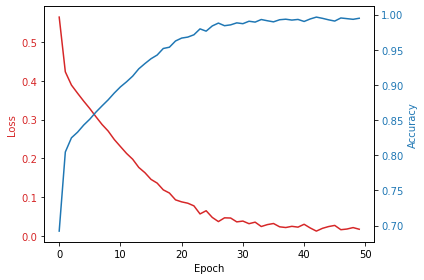

In [10]:
# Plot both the loss and accuracy
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(gru_history.history['loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(gru_history.history['accuracy'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

## (3) Build a Bidirectional LSTM model for classifying IMDB dataset. (30%)

#### 建構 BiLSTM 模型 

* 因為前面資料都處理好了，這邊只需要從模型建構開始即可
* 把 add(GRU(64)) 換成 add(Bidirectional(LSTM(64))) 就可以了
* BiLSTM 是 LSTM 模型的一種變體，可以從兩個方向（由前往後和由後往前）處理資料，因此可以有效地從過去和未來的訊息中獲得上下文之間的關係。
* RNN-GRU 也是一種循環神經網絡，是 RNN 的變體，目的於克服 RNN 中的梯度消失問題。如前所述，它僅用 2 個門來調節通過訊息，因此 GRU 比 LSTM 相對簡單，需要的計算資源也較少。

In [14]:
biLstm_model = Sequential(name="BiLSTM")
biLstm_model.add(Input(shape=(1,), dtype="string"))
biLstm_model.add(vectorize_layer)
biLstm_model.add(Embedding(max_tokens + 1, 128))
biLstm_model.add(Bidirectional(LSTM(64)))
biLstm_model.add(Dense(64, activation="relu"))
biLstm_model.add(Dense(1, activation="sigmoid"))
biLstm_model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

#### 印出 BiLSTM 模型 summary

In [15]:
print(biLstm_model.summary())

Model: "BiLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 128)          128128    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 235,265
Trainable params: 235,265
Non-trainable params: 0
_________________________________________________________________
None


#### 開始訓練

In [16]:
biLstm_history = biLstm_model.fit(train_data, epochs= 50)

Epoch 1/50
782/782 [==============================] - 59s 72ms/step - loss: 0.5087 - accuracy: 0.7447
Epoch 2/50
782/782 [==============================] - 69s 89ms/step - loss: 0.4266 - accuracy: 0.8031
Epoch 3/50
782/782 [==============================] - 69s 88ms/step - loss: 0.3928 - accuracy: 0.8218
Epoch 4/50
782/782 [==============================] - 67s 86ms/step - loss: 0.3663 - accuracy: 0.8360
Epoch 5/50
782/782 [==============================] - 68s 86ms/step - loss: 0.2998 - accuracy: 0.8705
Epoch 7/50
782/782 [==============================] - 68s 87ms/step - loss: 0.2725 - accuracy: 0.8834
Epoch 8/50
782/782 [==============================] - 67s 85ms/step - loss: 0.2536 - accuracy: 0.8910
Epoch 9/50
782/782 [==============================] - 66s 85ms/step - loss: 0.2243 - accuracy: 0.9046
Epoch 10/50
782/782 [==============================] - 66s 84ms/step - loss: 0.1750 - accuracy: 0.9282
Epoch 12/50
782/782 [==============================] - 65s 84ms/step - loss: 0.15

#### 為了和 BiRNN 結果進行比較，下一題才會把結果和 BiRNN 的結果一起印出

## (4) Compare whether a Bidirectional RNN model or a Bidirectional LSTM model perform better. Please provide some illustration. (20%)

#### 建構 BiRNN 模型

* BiRNN 結合了前向和後向處理的神經網路架構。在標準 RNN 中，每個 time step 的輸出僅取決於該 step 的輸入和前一 time step 的隱藏狀態。但是，BiRNN 使用兩個獨立的隱藏狀態從兩方處理輸入序列，即一個隱藏狀態由前往後處理輸入序列，而另一個隱藏狀態由後往前處理輸入序列。
* bidirectional 的方式在自然語言處理任務中特別有用，例如情感分析或機器翻譯，其中單詞的含義可能取決於其前後的單詞。
* 在 BiRNN 中兩個獨立隱藏層的輸出被連接起來並傳遞到最終輸出層進行分類或回歸任務。

In [17]:
biRnn_model = Sequential(name="BiRNN")
biRnn_model.add(Input(shape=(1,), dtype="string"))
biRnn_model.add(vectorize_layer)
biRnn_model.add(Embedding(max_tokens + 1, 128))
biRnn_model.add(Bidirectional(SimpleRNN(64)))
biRnn_model.add(Dense(64, activation="relu"))
biRnn_model.add(Dense(1, activation="sigmoid"))
biRnn_model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)


#### 印出 BiRNN 模型 summary

In [18]:
print(biRnn_model.summary())

Model: "BiRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 100)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 128)          128128    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               24704     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 161,153
Trainable params: 161,153
Non-trainable params: 0
_________________________________________________________________
None


#### 開始訓練

In [19]:
biRnn_history = biRnn_model.fit(train_data, epochs= 50)

Epoch 1/50
782/782 [==============================] - 32s 41ms/step - loss: 0.5262 - accuracy: 0.7439
Epoch 6/50
782/782 [==============================] - 32s 41ms/step - loss: 0.5248 - accuracy: 0.7432
Epoch 7/50
782/782 [==============================] - 30s 39ms/step - loss: 0.5959 - accuracy: 0.6825
Epoch 8/50
782/782 [==============================] - 34s 44ms/step - loss: 0.5929 - accuracy: 0.6788
Epoch 9/50
782/782 [==============================] - 34s 44ms/step - loss: 0.5667 - accuracy: 0.7052
Epoch 10/50
782/782 [==============================] - 31s 40ms/step - loss: 0.5559 - accuracy: 0.7137
Epoch 11/50
782/782 [==============================] - 34s 44ms/step - loss: 0.5304 - accuracy: 0.7372
Epoch 12/50
782/782 [==============================] - 34s 44ms/step - loss: 0.5192 - accuracy: 0.7516
Epoch 13/50
782/782 [==============================] - 34s 43ms/step - loss: 0.5025 - accuracy: 0.7660
Epoch 14/50
782/782 [==============================] - 34s 43ms/step - loss: 0

#### 讓 BiLSTM 模型預測

In [20]:
# positive: high score
print(biLstm_model.predict([
  "i loved it! highly recommend it to anyone and everyone looking for a great movie to watch.",
]))

# negative: low score
print(biLstm_model.predict([
  "this was awful! i hated it so much, nobody should watch this. the acting was terrible, the music was terrible, overall it was just bad.",
]))

[[1.]]
[[5.3918366e-13]]


#### 讓 BiRNN 模型預測

In [22]:
# positive: high score
print(biRnn_model.predict([
  "i loved it! highly recommend it to anyone and everyone looking for a great movie to watch.",
]))

# negative: low score
print(biRnn_model.predict([
  "this was awful! i hated it so much, nobody should watch this. the acting was terrible, the music was terrible, overall it was just bad.",
]))

[[0.8529196]]
[[0.04306087]]


#### BiLSTM 的 accuracy

In [23]:
loss, accuracy = biLstm_model.evaluate(test_data)
print(f"Test accuracy: {accuracy}")

782/782 [==============================] - 15s 17ms/step - loss: 1.9973 - accuracy: 0.7435
Test accuracy: 0.7434800267219543


#### BiRNN 的 accuracy

In [24]:
loss, accuracy = biRnn_model.evaluate(test_data)
print(f"Test accuracy: {accuracy}")

782/782 [==============================] - 9s 11ms/step - loss: 0.7018 - accuracy: 0.6164
Test accuracy: 0.6164399981498718


#### 畫出 BiLSTM 的訓練過程

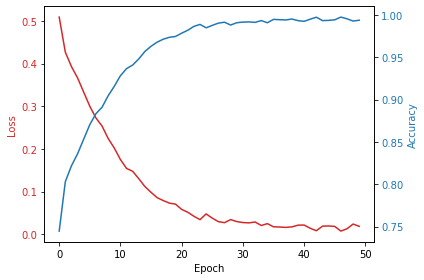

In [25]:
# Plot both the loss and accuracy
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(biLstm_history.history['loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(biLstm_history.history['accuracy'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

#### 畫出 BiRNN 的訓練過程

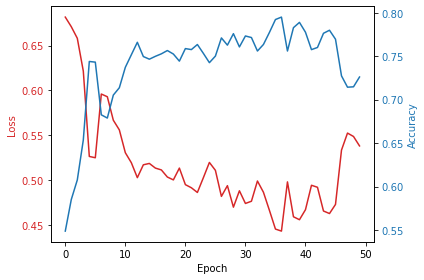

In [26]:
# Plot both the loss and accuracy
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(biRnn_history.history['loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(biRnn_history.history['accuracy'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

#### 把模型存起來

In [27]:
gru_model.save_weights('RNN-GRU')
biLstm_model.save_weights('BiLSTM')
biRnn_model.save_weights('BiRNN')

## Reflection

可以發現在做 Deep Learning 時，模型架構的方式萬變不離其宗，基本上如果你想用什麼新的模型，就是把你要的模型那一層加進去。這邊也發現以模型複雜程度來說，BiLSTM 包含更多的參數和計算步驟。因此，在訓練時，BiLSTM 模型需要更長的時間來學習和調整這些參數，所以是三者中在同樣資料集、同樣設定的狀況下，每個 epoch 訓練最久的模型。

分別比較三種模型的結果，我比較訝異的是竟然是 RNN-GRU 的表現最好，BiLSTM 則次之，且二者的訓練過程之表現差異不大。因此這邊我推測是因為 IMDB 資料集的文本較短，RNN-GRU 的門控機制可以控制通過的訊息，提取更好的特徵。而雖然 BiLSTM 也有此機制，但雙向傳遞可能導致獲取過多的上下文資訊，使 overfitting 的情況發生，最後的 accuracy 反而不如 RNN-GRU。但這只是一種可能性，具體的原因可能需要更多的分析和實驗驗證。不過使用 RNN-GRU 和 BiLSTM 預測時，結果還是令人感到欣慰的，因為同樣的句子 positive 的結果都是 1，而 negative 的結果可以觀察到 BiLSTM 預測出來的數值較 RNN-GRU 更趨近於 0，我想，這在某種程度上證明 BiLSTM 可能更細緻一點。 

接著比較 BiLSTM 和 BiRNN 的結果。雖然二者都是 Bidirectional 結構，但結果顯示，二者的表現還是有所差距。我想，可以從二者的結構來解釋。BiRNN 中的 RNN 只有一個簡單的循環神經網路層，對於短期記憶效果好，但是長期記憶效果較差。LSTM 則具有三個控制門，可以處理長、短期記憶，也解決了梯度消失的問題。因此，可能在大部分情況下，處理序列數據時，BiLSTM 優於 BiRNN。從訓練過程的圖片中也能觀察到，BiLSTM 比 BiRNN 還要穩定許多，基本上在一定次數的 epochs 之後都能趨於穩定，而 BiRNN 則好像受到文本的影響更大一些，一直到第 50 個 epoch 都還是各種竄動的狀態。而且在進行預測時，BiRNN 也是三者中唯一 positive 沒有等於 1，且 negative 數值最大的一個。

透過這些比較，我猜測也許需要更長的文本才更能體現出 BiLSTM 的優勢，不然在一般情況下，RNN-GRU 已經能夠達到不錯的狀態且訓練時間也的確縮短許多。而 BiRNN 對我而言則像是硬要把 BiLSTM 中 Bidirectional 的概念放進來的模型😂，而忽略了其簡單的結構若是給它太多的資訊反而容易造成不穩定之反效果。最後，想要感嘆一下原來用 Gate 來控制輸入訊息是這麼重要的事情，因為 RNN-GRU 雖然沒有用到 Biderectional 的方式來獲取更多上下文資訊，但加入了 LSTM 中 Gate 的概念就能夠在縮短訓練時間的同時達到好的訓練結果。反觀 BiRNN 的結果，也許就是因為沒有好好過濾訊息（Gate），卻又加入太多上下文資訊（Biderectional），反而是此任務之三者中效果最差的模型。